# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [9]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

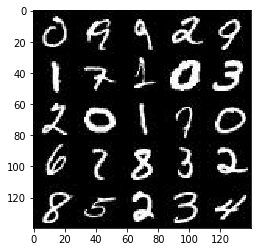

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

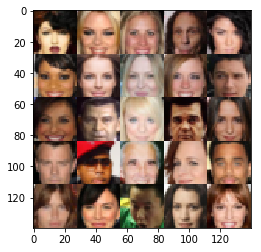

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=())
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def leaky_relu(x, alpha):
    return tf.maximum(x, alpha * x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    training = True
    alpha = 0.01
    drop_rate = 0.2

    def conv_layer(prev_layer, layer_depth, with_batch_normalization=True):
        layer = tf.layers.conv2d(prev_layer, layer_depth, kernel_size=5, strides=2, padding='same', use_bias=False, activation=None,
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        if (with_batch_normalization):
            layer = tf.layers.batch_normalization(layer, training=training)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer

    with tf.variable_scope("discriminator", reuse=reuse):
        layer = conv_layer(images, layer_depth=64, with_batch_normalization=False)
        layer_depths = [128, 256]
        for layer_depth in layer_depths:
            prev_layer = layer
            layer = conv_layer(prev_layer, layer_depth)

        orig_shape = layer.get_shape().as_list()
        conv_layer = tf.reshape(layer, shape=(-1, orig_shape[1] * orig_shape[2] * orig_shape[3]))
        
        logits = tf.layers.dense(conv_layer, 1, activation=None)
        out = tf.nn.sigmoid(logits) 

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, drop_rate=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    
    def full_connected(pre_layer, num_units):
        layer = tf.layers.dense(pre_layer, num_units, use_bias=False, activation=None,
                               kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer
    
    def conv_layer(prev_layer, layer_depth, strides=2):
        layer = tf.layers.conv2d_transpose(prev_layer, layer_depth, kernel_size=5, strides=strides, padding='same', use_bias=False, activation=None,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer

    with tf.variable_scope("generator", reuse=False if is_train==True else True):
        x = full_connected(z, 7*7*512)
        x = tf.reshape(x, shape=(-1, 7, 7, 512))

        layer_depths = [256, 128] # 14*14*256, 28*28*128
        layer = x
        for layer_depth in layer_depths:
            prev_layer = layer
            layer = conv_layer(prev_layer, layer_depth)

        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, kernel_size=5, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False, drop_rate=0.0),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every=100
    n_sample_images = 25
    steps = 0
    losses = []
   
    batches, image_width, image_height, image_channels = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2.0
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_sample_images, input_z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 21.4631
Epoch 1/2... Discriminator Loss: 11.8647... Generator Loss: 27.4521
Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 6.1255
Epoch 1/2... Discriminator Loss: 0.1698... Generator Loss: 3.5249
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 2.4528... Generator Loss: 7.1132
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 5.5533
Epoch 1/2... Discriminator Loss: 1.7049... Generator Loss: 0.2872
Epoch 1/2... Discriminator Loss: 1.8276... Generator Loss: 0.3304
Epoch 1/2... Discriminator Loss: 2.3905... Generator Loss: 0.1724


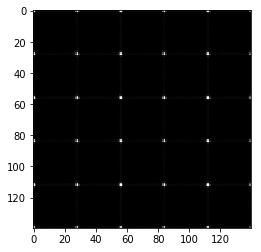

Epoch 1/2... Discriminator Loss: 1.7896... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.6812... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 1.9005... Generator Loss: 0.2206
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 2.0942... Generator Loss: 0.1720
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.3219
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 0.3589
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.2007


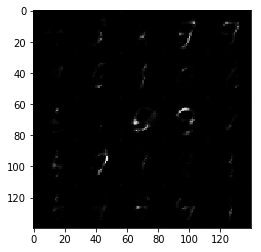

Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 2.0510... Generator Loss: 0.1880
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.6781
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 1.6458
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 1.3897
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 1.2199
Epoch 1/2... Discriminator Loss: 1.7814... Generator Loss: 0.2874
Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 0.3766


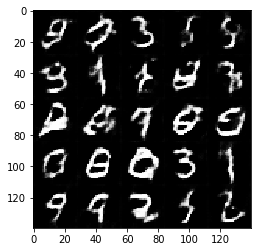

Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.4268
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 2.1782... Generator Loss: 0.1627
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.9129... Generator Loss: 0.2143
Epoch 1/2... Discriminator Loss: 0.8635... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.2554
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.5504


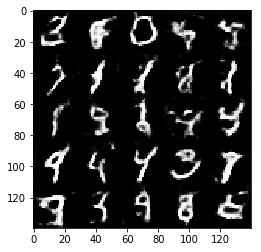

Epoch 1/2... Discriminator Loss: 1.7878... Generator Loss: 0.2535
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.4253
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.9976
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6615


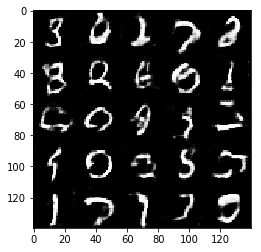

Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.0689
Epoch 1/2... Discriminator Loss: 1.4761... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.3630
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 1.7082... Generator Loss: 0.2553


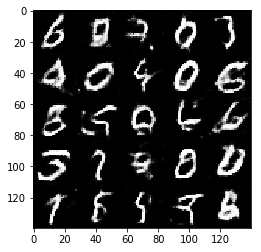

Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 1.6370... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 2.1047... Generator Loss: 0.1840
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.3137
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.3901
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.4619
Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.3006


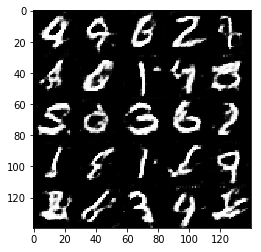

Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 0.4659
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 2.0209... Generator Loss: 0.2048
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.4320
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.6983... Generator Loss: 0.3146
Epoch 1/2... Discriminator Loss: 0.8896... Generator Loss: 1.3092
Epoch 1/2... Discriminator Loss: 1.6475... Generator Loss: 0.3059


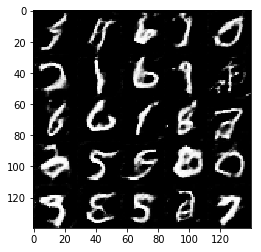

Epoch 1/2... Discriminator Loss: 1.9472... Generator Loss: 0.2436
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.1045
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.2693
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 2.0764... Generator Loss: 0.2041


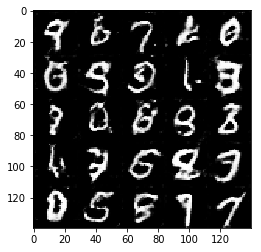

Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.3661
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 2.0159
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.4967
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.9281


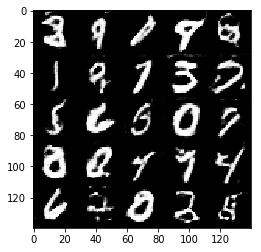

Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.9509
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 2.0195
Epoch 1/2... Discriminator Loss: 2.2691... Generator Loss: 0.1656
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 1.0770
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.3578
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.3874


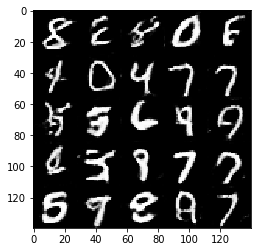

Epoch 1/2... Discriminator Loss: 1.9165... Generator Loss: 2.1983
Epoch 1/2... Discriminator Loss: 1.4910... Generator Loss: 2.1277
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 1.4532... Generator Loss: 0.3777
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.3490
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.4168


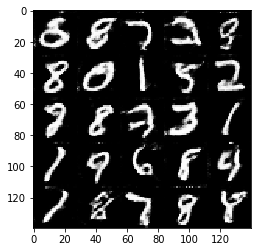

Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.6401
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.2876
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.6606
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 2.1550
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 2.1954... Generator Loss: 0.1439
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 2.2290


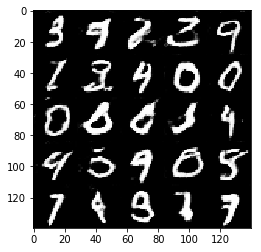

Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.5516
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 1.7836
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.7488
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.5846


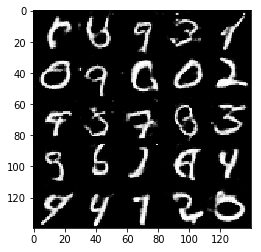

Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.4982
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 0.8696
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 0.7798... Generator Loss: 1.3692


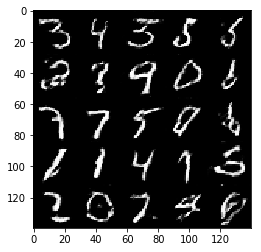

Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.3156
Epoch 1/2... Discriminator Loss: 2.4785... Generator Loss: 0.1105
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 1.5168... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.5042
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.6103... Generator Loss: 0.3397
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.7049... Generator Loss: 0.2832


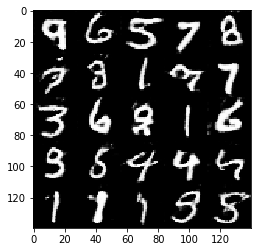

Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.0626
Epoch 1/2... Discriminator Loss: 1.8599... Generator Loss: 0.2135
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.6943


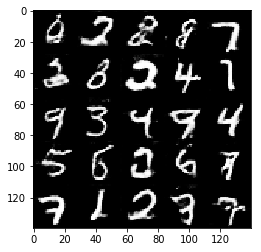

Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 2.3785
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 1.9670
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 2.2865... Generator Loss: 0.1512
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 1.0105


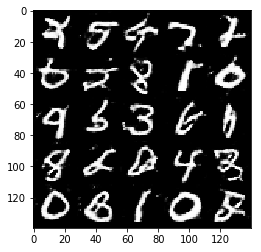

Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.5165
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.7207
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.3746
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 2.1669
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 1.3080


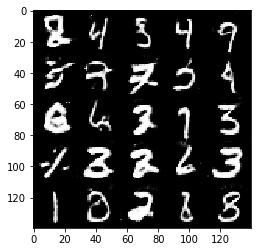

Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 1.4007
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.6058
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 1.9402
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.7769


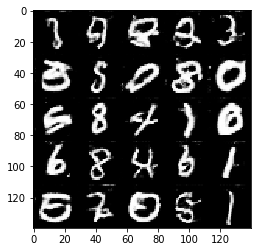

Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 0.6627... Generator Loss: 1.1087
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.4754
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.4361
Epoch 2/2... Discriminator Loss: 1.8358... Generator Loss: 0.3462
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 2.5490... Generator Loss: 4.7295
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 0.4624


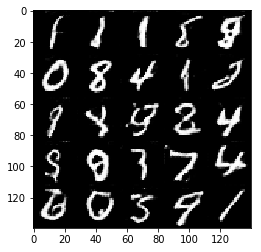

Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.3463
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 3.0098
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 0.6111... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 0.6564... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 1.9875... Generator Loss: 0.2333
Epoch 2/2... Discriminator Loss: 2.1005... Generator Loss: 0.1937


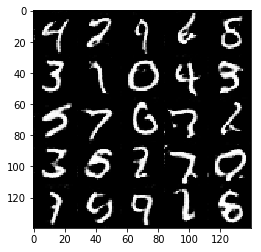

Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 2.7532
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 0.9658
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.7708
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 1.9260
Epoch 2/2... Discriminator Loss: 0.9491... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 0.4251... Generator Loss: 2.0644


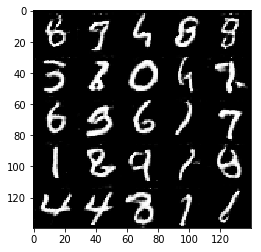

Epoch 2/2... Discriminator Loss: 0.5576... Generator Loss: 1.2669
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 1.5185
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 2.2616
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.5353
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 2.1381
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 0.9977


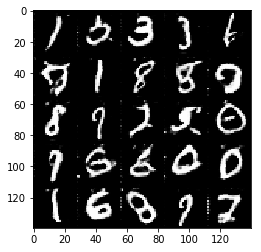

Epoch 2/2... Discriminator Loss: 0.6036... Generator Loss: 1.2739
Epoch 2/2... Discriminator Loss: 1.8715... Generator Loss: 0.2857
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 1.8052... Generator Loss: 0.3276
Epoch 2/2... Discriminator Loss: 0.5552... Generator Loss: 1.4207
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 0.3082... Generator Loss: 1.8825
Epoch 2/2... Discriminator Loss: 0.7216... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 1.7267... Generator Loss: 0.3369
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 2.0775


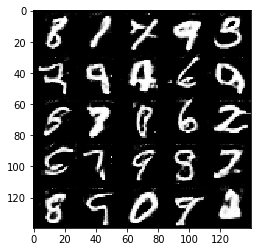

Epoch 2/2... Discriminator Loss: 2.0159... Generator Loss: 0.2325
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.4052
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.8811... Generator Loss: 0.2943
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 1.8264
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.2042... Generator Loss: 3.5007
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 2.2821
Epoch 2/2... Discriminator Loss: 0.5577... Generator Loss: 1.3823


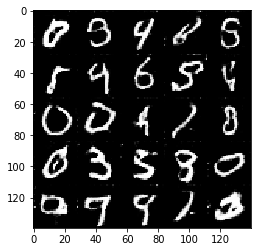

Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 1.6703
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 2.1807
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 0.5372... Generator Loss: 1.5884
Epoch 2/2... Discriminator Loss: 1.9913... Generator Loss: 0.2439
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.0820


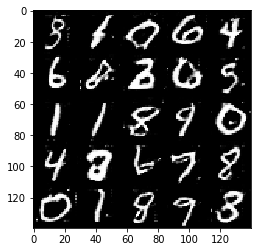

Epoch 2/2... Discriminator Loss: 2.9618... Generator Loss: 0.1370
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 0.3993... Generator Loss: 1.7860
Epoch 2/2... Discriminator Loss: 0.6929... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 4.5500... Generator Loss: 0.0274
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.7541


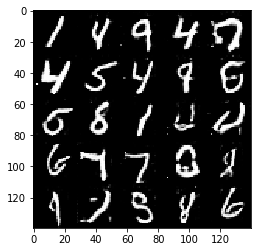

Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.5988... Generator Loss: 0.4160
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 1.7008
Epoch 2/2... Discriminator Loss: 0.5570... Generator Loss: 1.3311
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.1648
Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 1.2488
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 3.1226
Epoch 2/2... Discriminator Loss: 0.4514... Generator Loss: 1.6214


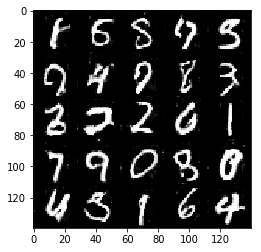

Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.6441... Generator Loss: 3.6988
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.7386... Generator Loss: 0.2927
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 0.5564
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 3.4915
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.5207


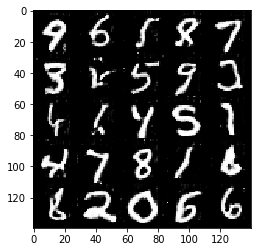

Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 0.5597... Generator Loss: 1.3787
Epoch 2/2... Discriminator Loss: 0.6918... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 0.6161... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 2.7156... Generator Loss: 0.1238
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 2.0466
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.8102


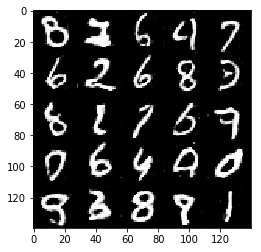

Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.9040
Epoch 2/2... Discriminator Loss: 0.4609... Generator Loss: 1.6662
Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 1.3557
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 1.8148
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 3.6884
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 1.6212
Epoch 2/2... Discriminator Loss: 1.9907... Generator Loss: 0.2665
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 1.5867... Generator Loss: 0.4582


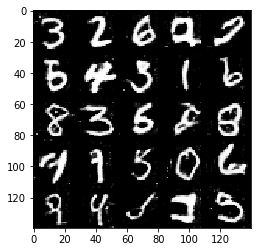

Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.3387
Epoch 2/2... Discriminator Loss: 0.3227... Generator Loss: 1.8255
Epoch 2/2... Discriminator Loss: 0.6443... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.6026
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 0.9371
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.4766... Generator Loss: 1.5558
Epoch 2/2... Discriminator Loss: 0.4464... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 0.3416... Generator Loss: 2.3417


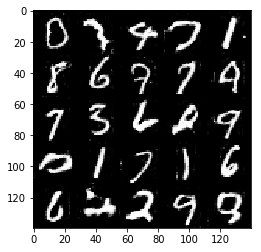

Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.3089
Epoch 2/2... Discriminator Loss: 2.3177... Generator Loss: 0.2208
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.6725
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.6871
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 1.5469... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 1.6546... Generator Loss: 0.3130


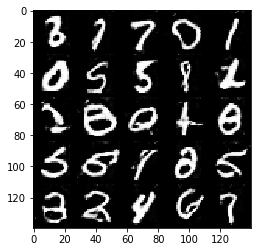

Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.5619... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 0.5066... Generator Loss: 1.7565
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 3.8650
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.6328
Epoch 2/2... Discriminator Loss: 0.6226... Generator Loss: 1.3726
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 1.1715


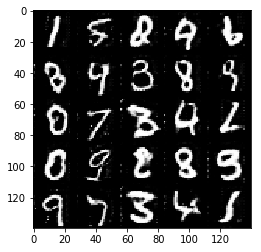

Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 3.2937
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.0048
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 2.3816... Generator Loss: 0.1922
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 1.7741
Epoch 2/2... Discriminator Loss: 0.5450... Generator Loss: 1.1295


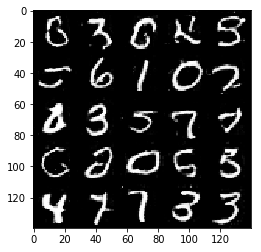

Epoch 2/2... Discriminator Loss: 0.5171... Generator Loss: 2.5831
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 1.7097
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 0.5289... Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 0.7408
Epoch 2/2... Discriminator Loss: 0.2929... Generator Loss: 2.6174
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 2.4124
Epoch 2/2... Discriminator Loss: 1.6858... Generator Loss: 0.2827


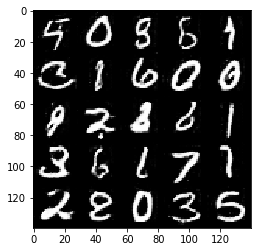

Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 1.5965
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 1.5518
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 3.6590
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 2.5148


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 17.4554
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 11.1358
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 6.9723
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 16.6878
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 7.7343
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 5.2615
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 4.0465
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 3.4836
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 1.9376
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 2.5835


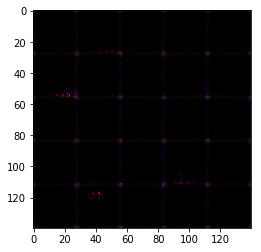

Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.6302
Epoch 1/1... Discriminator Loss: 2.5004... Generator Loss: 0.1562
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 2.3907... Generator Loss: 0.1159
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.4817


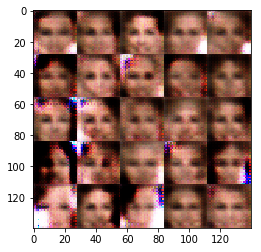

Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.7824... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 2.0685
Epoch 1/1... Discriminator Loss: 1.7936... Generator Loss: 0.2850


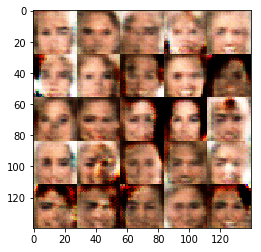

Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.4184
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 2.2720... Generator Loss: 2.6479
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.7436


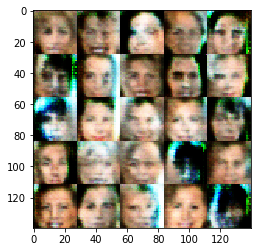

Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.3567
Epoch 1/1... Discriminator Loss: 1.9022... Generator Loss: 1.9215
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.6915... Generator Loss: 0.2518
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 1.5932
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.2724
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.6741


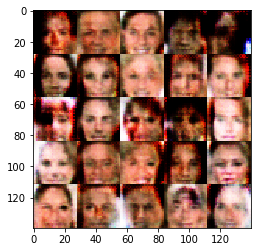

Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 2.1288... Generator Loss: 0.1723
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.9927... Generator Loss: 0.1882
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.6730


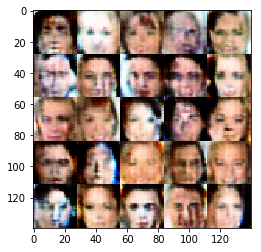

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.3450
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 1.9358
Epoch 1/1... Discriminator Loss: 1.8131... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7269


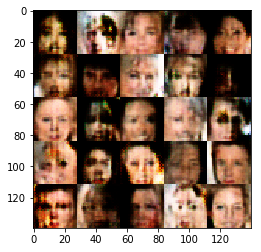

Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 0.9574


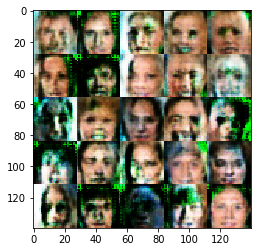

Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 2.2988... Generator Loss: 0.1363
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 1.0647


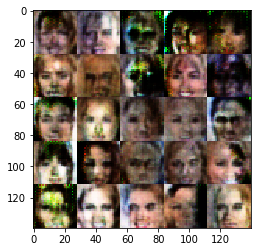

Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.2572
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.9299... Generator Loss: 2.0969
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 0.7985


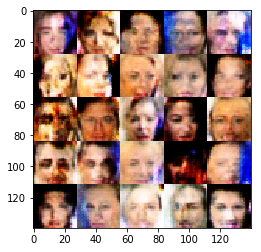

Epoch 1/1... Discriminator Loss: 1.8871... Generator Loss: 0.2155
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.4582


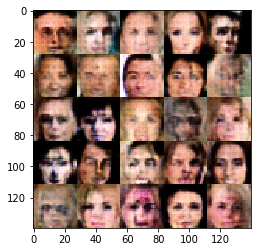

Epoch 1/1... Discriminator Loss: 1.7155... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.6694... Generator Loss: 0.3128
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.4218


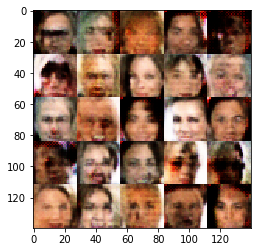

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8899


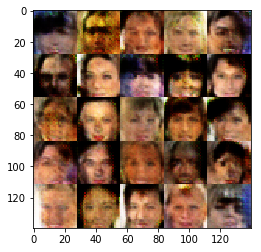

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.8097


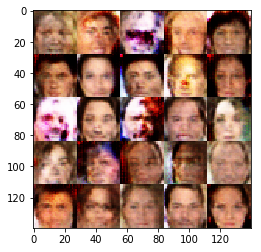

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.8672... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.3514
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8729


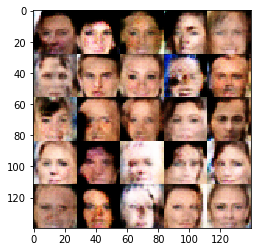

Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 0.2487
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 2.1153... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.9743... Generator Loss: 0.1862
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7497


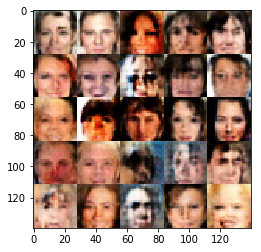

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.2743
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.4876


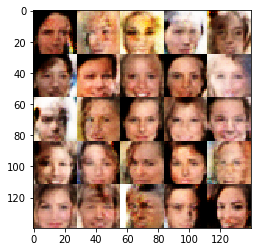

Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.3319
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.5274


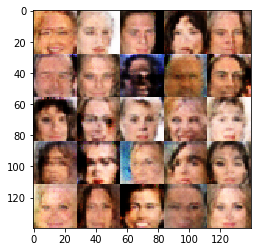

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.3345
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.4404


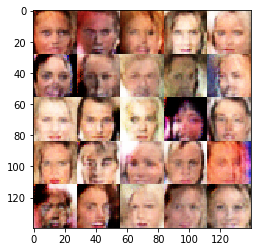

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.3145


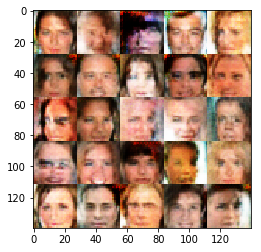

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.5539


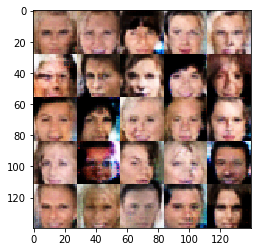

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.2888
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.5714


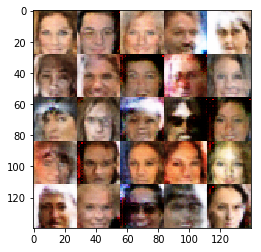

Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.3406
Epoch 1/1... Discriminator Loss: 2.0081... Generator Loss: 0.1833
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.3780
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.9915


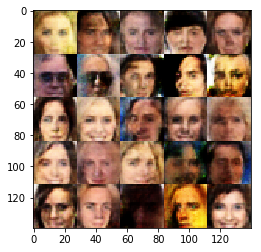

Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 1.1037


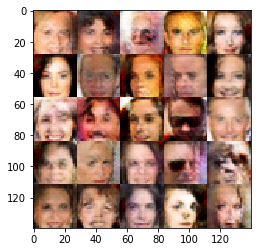

Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.5394


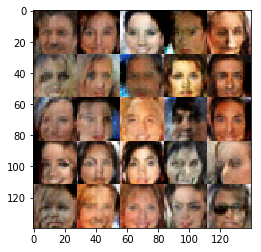

Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7921


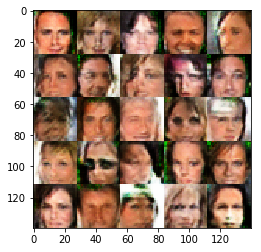

Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.3566


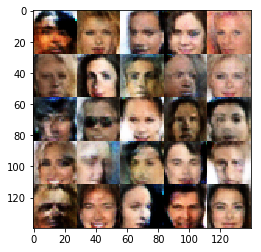

Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 2.0387... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4626


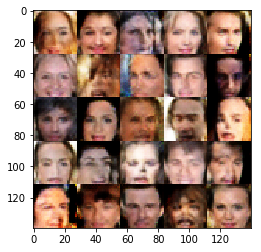

Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6588


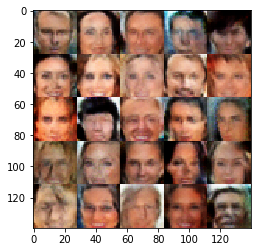

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.4962


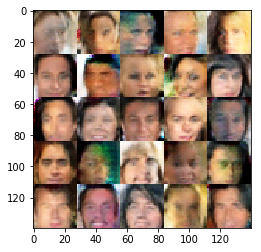

Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.3464
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5236


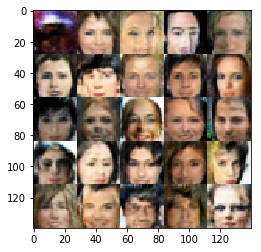

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.4569


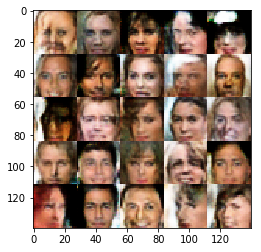

Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.3535
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5028


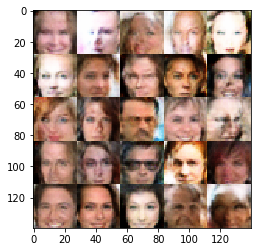

Epoch 1/1... Discriminator Loss: 1.6690... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.3741


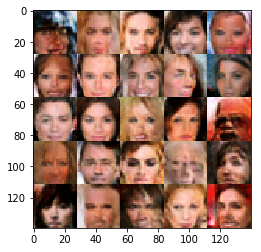

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.6645... Generator Loss: 0.2818
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5691


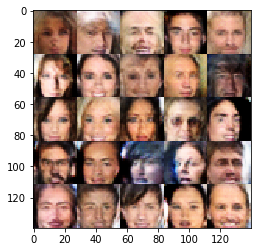

Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.5509


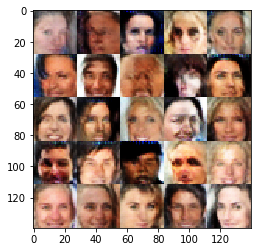

Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8761


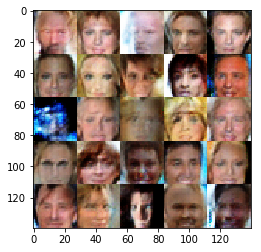

Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.3211


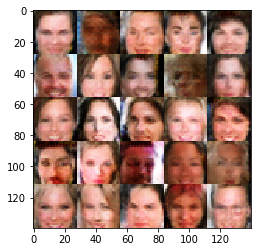

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.4799
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.3874


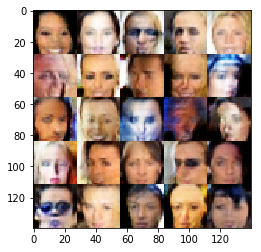

Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7099


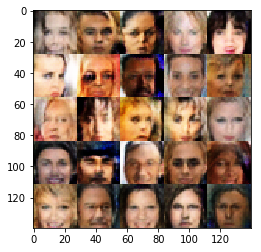

Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.7843... Generator Loss: 0.3553
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.4882


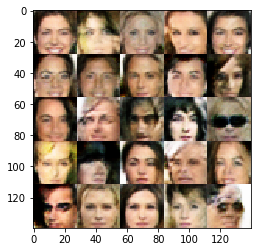

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6176


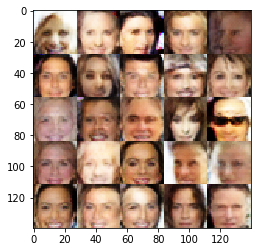

Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5329


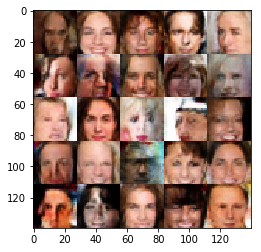

Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.6358


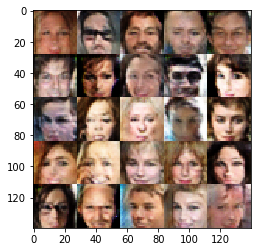

Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.3707
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.4719


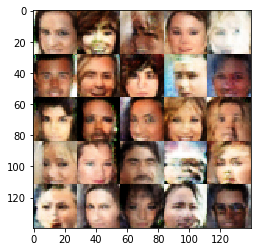

Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5157


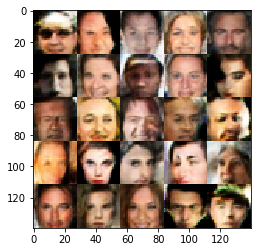

Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.3505


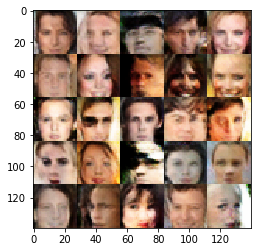

Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.2974
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.7991... Generator Loss: 0.3464


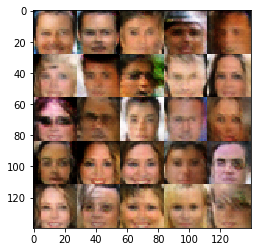

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.4103


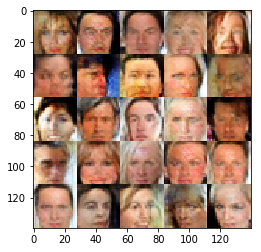

Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.8501... Generator Loss: 0.2970
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.5974


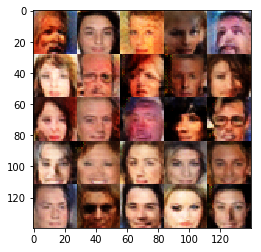

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6996


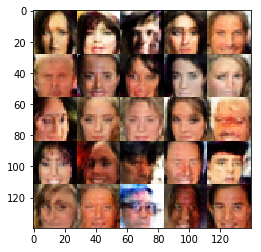

Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9612


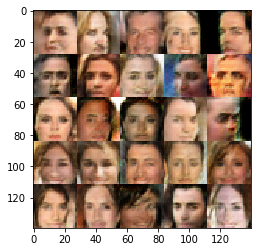

Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.5447


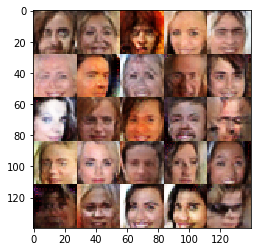

Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.4978


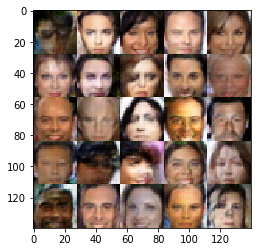

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.6626... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6897


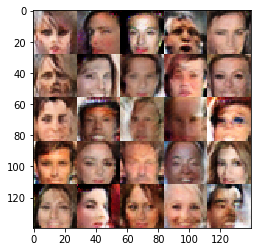

Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.4873


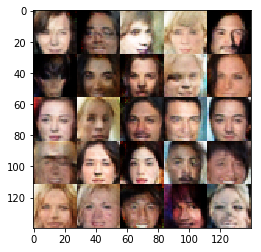

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.5240


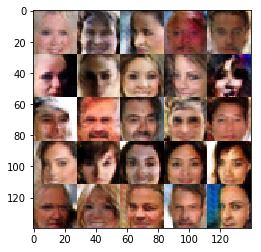

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6642


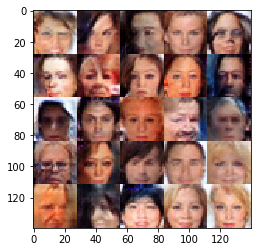

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.4658


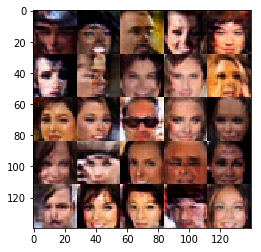

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6057


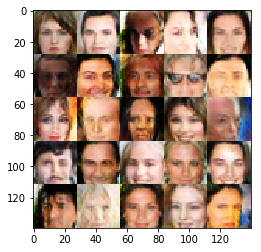

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6050


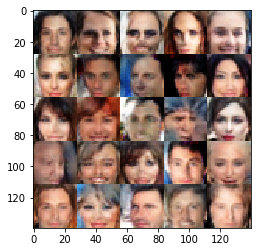

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.4236
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.4568


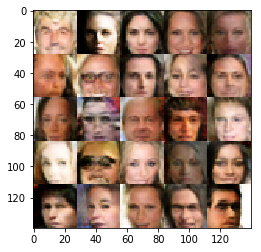

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5115


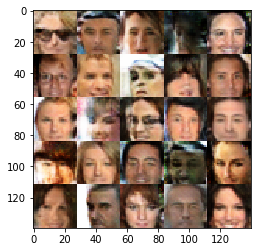

Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5666


In [22]:
#batch_size = 32
batch_size = 32
z_dim = 100
learning_rate = 0.0008
#learning_rate = 0.0001, 0.0008, 0.002
beta1 = 0.4
#beta1 = 0.2, 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.